In [12]:
# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
import os

# Feature extraction
from scipy.signal import peak_widths
from scipy.stats import entropy
from PeakDetection import OS_CFAR

# Classifiers:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# For data preprocessing:
from FeatureExtraction import loadDataSet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# For visualization:
from sklearn.inspection import DecisionBoundaryDisplay

In [103]:
methods = ["kNN",            # k nearest neighbors
            "RBF SVM",       # support vector machine with gaussian kernel
            "GP",            # Gaussian process
            "Decision Tree", # decision tree
            "Random Forest", # random forest
            "NN",            # neural network
            "AdaBoost",      # ensemble learning
            "NB",            # naive bayer
            "QDA"]           # quadratic discriminant analysis
classifiers = [KNeighborsClassifier(4), # k nearest neighbours,
               SVC(kernel="rbf", decision_function_shape='ovo', gamma=2, C=1), # support vector machine with RBF kernel
               GaussianProcessClassifier(1.0 * RBF(1.0)),
               DecisionTreeClassifier(max_depth=5),
               RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
               MLPClassifier(alpha=1, max_iter=1000),
               AdaBoostClassifier(),
               GaussianNB(),
               QuadraticDiscriminantAnalysis()]        

In [65]:
# Data Loading and Processing

def loadDataSet(filename):
    with open(filename, 'rb') as f:
        dataSet = pickle.load(f)
    for _, x, label in dataSet:
        y = label[1]
        try:
            X = np.vstack((X, x))
            Y = np.vstack((Y, y))
        except(NameError):
            X = x
            Y = y
    return X, Y

def extractFeatures(x):
    features = dict()
    # Number of peaks, location of peaks:
    peak_idx, n_peak, _ = OS_CFAR(x, N=200, T=7, N_protect=20)
    features["N_peaks"] = n_peak
    # Entropy with white noise:
    np.random.seed(1)
    whiteNoise = np.random.normal(0.25, 2.52, size=1024)
    #noiseCorr = entropy(0.5*(whiteNoise/np.max(np.abs(whiteNoise)))+1, 0.5*(x/np.max(np.abs(x)))+1)
    #features["White Noise Entropy"] = noiseCorr
    if peak_idx:
        peaks = np.sort(x[peak_idx])
        # Width and distance among peaks:
        widths = peak_widths(x, peak_idx, rel_height=0.7)
        d_peaks = [abs(v - peak_idx[(i+1)%len(peak_idx)]) for i, v in enumerate(peak_idx)][:-1]
        # Minimum distance:
        if d_peaks:
            d_min = np.min(d_peaks)
        else:
            d_min = 1024
        features["d_min"] = d_min
        # Width of maximum peak:
        w_maxPeak = widths[0][np.argmax(x[peak_idx])]
        #features["w_maxPeak"] = w_maxPeak
        # Summed heights of non dominant peaks, normalized to maximum peak
        if len(peaks)>1:
            minorToMajor = np.mean(peaks[:-1]) / peaks[-1]
        else:
            minorToMajor = 0
        #features["Minor To Major Peaks"] = minorToMajor
        # SNR or max value:
        x_max = peaks[-1]
        features["Max Peak height"] = x_max
    else:
        pass
        # No peaks existent
        features["d_min"] = 0
        #features["w_maxPeak"] = 1024
        #features["Minor To Major Peaks"] = 2
        features["Max Peak height"] = 0
    return features

def to_features(X):
        for x in X:
            v = np.asarray(list(extractFeatures(x).values()))
            try:
                V = np.vstack((V, v))
            except(NameError):
                V = v
        return V
    
def plot_data(X, Y):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(X[Y==2,0],X[Y==2,1],X[Y==2,2], label="Very good")
    ax.scatter(X[Y==1,0],X[Y==1,1], X[Y==1,2],label="Good")
    ax.scatter(X[Y==-1,0],X[Y==-1,1], X[Y==-1,2],label="Ok")
    ax.scatter(X[Y==-2,0],X[Y==-2,1], X[Y==-2,2],label="Bad")
    ax.legend()
    ax.grid()
    plt.show()

In [ ]:
# Data loading
X, Y = loadDataSet('dataSet')
Y = np.ravel(Y) #delete inner dimension

V = to_features(X)

Retrieved 212 training and 24 test data points


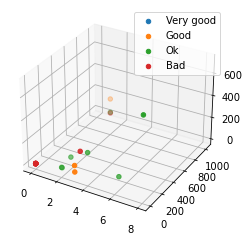

In [101]:
# Splitting Data
V_train, V_test, Y_train, Y_test = train_test_split(V, Y, test_size=0.1)

print("Retrieved {} training and {} test data points".format(len(Y_train),len(Y_test)))

# Data Visualization (only for 3-dims)
if V_test.shape[1] == 3:
    plot_data(V_test, Y_test)

In [81]:
# (Optional:) Data scaling

scaler = StandardScaler()
scaler.fit(V)
scale, mean = scaler.scale_, scaler.mean_

V_sc = scaler.transform(V)
V_train, V_test, Y_train, Y_test = train_test_split(V_sc, Y, test_size=0.3)

Retrieved 165 training and 71 test data points


In [105]:
# Classification

method = "RBF SVM"
classifier = classifiers[methods.index(method)]

# Train the model
classifier.fit(V_train, Y_train)

# Test the model
score_train = classifier.score(V_train, Y_train)
score_test  = classifier.score(V_test , Y_test)

print("Train Accuracy: {0}".format(score_train))
print("Test Accuracy: {0}".format(score_test))

Train Accuracy: 0.8773584905660378
Test Accuracy: 0.75
